# Unsupervised learning - K-means application
Goal of the excercise is to learn how to use K-means implementation in the Scikit-learn library to perform clustering and subsequent cluster analysis on a Titanic dataset.

In [15]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Load titanic dataset

In [16]:
df = pd.read_csv('data/titanic.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### How many missing values are in there?

In [17]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
dtype: int64

## We are going to cluster the passangers into defined number of groups
- It is clear that it is mandatory to select only a relevant subset of features and encode the categorical features as in the classification task performed in one of the previous lectures

In [18]:
df_clustering = df[['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
df_clustering = df_clustering.dropna()
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [19]:
df_clustering.shape

(712, 8)

In [20]:
df_clustering.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Lets encode categorical features
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
- https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing

We will use the same encoding methodology as in the classification lecture.

In [21]:
enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])[:20]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [22]:
enc.categories_

[array(['female', 'male'], dtype=object)]

In [23]:
enc = sklearn.preprocessing.OneHotEncoder(sparse=False)
enc.fit_transform(df_clustering[['Embarked']])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [24]:
enc.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [25]:
pd.get_dummies(df_clustering[['Embarked']]).head()

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1


In [26]:
df_encoded = pd.DataFrame(index = df_clustering.index)
df_encoded.head()

""
PassengerId
1
2
3
4
5


In [27]:
df_encoded['Sex'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df_clustering[['Sex']])

In [28]:
df_encoded = df_encoded.join(pd.get_dummies(df_clustering[['Embarked']]))
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,
1,1.0,0,0,1
2,0.0,1,0,0
3,0.0,0,0,1
4,0.0,0,0,1
5,1.0,0,0,1


### It is important to select the appropriate scaling method of the number features
- There are many ways how to do this - MinMax, StandardScaler, PowerTransform, ...
- This step heavily depends on a domain knowledge because the scales of the features have significant effect on a distances between couples of dataset instances
    - It is clear that if one variable is in range (0,1) and the second one is in a range (5000, 10 000), the difference in the second feature will be definitely more important than in the  first one from the numerical point of view
    - Although it is possible that from the domain point of view the first variable may be more important
    - Thus it is a good idea to at least transform the features into a simiiar scales so the effect on the distance value would be similiar
    - Transformation depends heavily on the statistical distribution of the feature
        - You can use PowerTransform for a heavy-tailed distribution, Standardization or MinMax normalization for normally distributed features etc.

<AxesSubplot:>

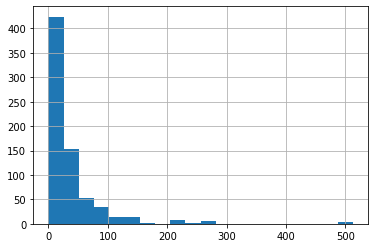

In [29]:
df_clustering.Fare.hist(bins=20)

In [30]:
df_clustering.Fare.describe()

count    712.000000
mean      34.567251
std       52.938648
min        0.000000
25%        8.050000
50%       15.645850
75%       33.000000
max      512.329200
Name: Fare, dtype: float64

In [31]:
enc = sklearn.preprocessing.PowerTransformer()
enc.fit_transform(df_clustering[['Fare']])[:20]

array([[-0.99765031],
       [ 1.28775742],
       [-0.90107255],
       [ 1.02427568],
       [-0.88411158],
       [ 1.00273178],
       [ 0.13202717],
       [-0.53475875],
       [ 0.48661962],
       [-0.10705645],
       [ 0.36394683],
       [-0.88411158],
       [ 0.52494282],
       [-0.91080102],
       [-0.15160295],
       [ 0.45530075],
       [-0.029469  ],
       [ 0.34315814],
       [-0.36978947],
       [-0.88691511]])

<AxesSubplot:>

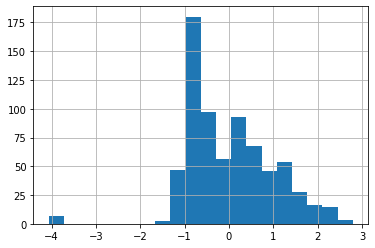

In [32]:
df_encoded['Fare'] = sklearn.preprocessing.PowerTransformer().fit_transform(df_clustering[['Fare']])
df_encoded.Fare.hist(bins=20)

In [33]:
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare
PassengerId,,,,,
1,1.0,0,0,1,-0.997650
2,0.0,1,0,0,1.287757
3,0.0,0,0,1,-0.901073
4,0.0,0,0,1,1.024276
5,1.0,0,0,1,-0.884112


In [34]:
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [35]:
df_encoded['Age'] = sklearn.preprocessing.minmax_scale(df_clustering.Age)

In [36]:
df_encoded = df_encoded.join(df_clustering[['Survived', 'Pclass', 'SibSp', 'Parch']])
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
PassengerId,,,,,,,,,,
1,1.0,0,0,1,-0.997650,0.271174,0,3,1,0
2,0.0,1,0,0,1.287757,0.472229,1,1,1,0
3,0.0,0,0,1,-0.901073,0.321438,1,3,0,0
4,0.0,0,0,1,1.024276,0.434531,1,1,1,0
5,1.0,0,0,1,-0.884112,0.434531,0,3,0,0


#### Check our preprocessed data by describe data

In [37]:
df_encoded.describe()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
count,712.000000,712.000000,712.000000,712.000000,7.120000e+02,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.636236,0.182584,0.039326,0.778090,7.484650e-17,0.367204,0.404494,2.240169,0.514045,0.432584
std,0.481420,0.386597,0.194506,0.415823,1.000703e+00,0.182118,0.491139,0.836854,0.930692,0.854181
min,0.000000,0.000000,0.000000,0.000000,-4.068874e+00,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,-8.841116e-01,0.246042,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,-1.749735e-01,0.346569,0.000000,2.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,5.770630e-01,0.472229,1.000000,3.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,2.796651e+00,1.000000,1.000000,3.000000,5.000000,6.000000


## Clustering

Use **Elbow method** to identify potentially ideal number of clusters in our data in **KMeans** algorithm.

There are two basic methods for evaluation of clusters quality:
1. SSE - Sum of squared distances of samples to their closest cluster center, this one is specific for **KMeans** algorithm. You can find it as **inertia_** attribute of KMeans sklearn object.
2. Silhouette Coefficient - calculated using the mean intra-cluster distance and the mean nearest-cluster distance

We ussually want to find number of clusters with low SSE and high Silhoutte coef.

- Take a look at [this](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) and [this](https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a)

#### Try different number of clusters from range <2, 10> for KMeans algorithm, save both evaluation criteria and plot dependency of criteria to number of clusters.

In [38]:
X = df_encoded.values

<AxesSubplot:xlabel='k'>

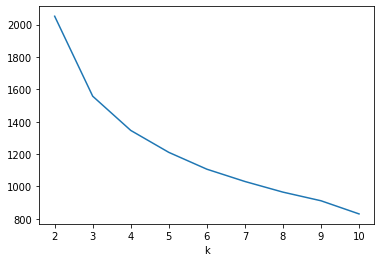

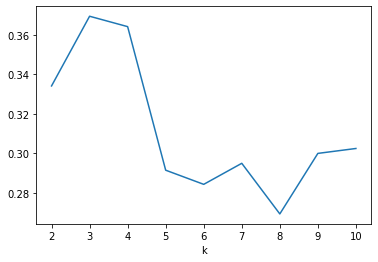

In [39]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

In [62]:
clustering = sklearn.cluster.KMeans(n_clusters=4, random_state=42)
clustering.fit(X)

KMeans(n_clusters=4, random_state=42)

#### How big are our clusters? How many 0, 1, .. are in vector?

In [63]:
pd.Series(clustering.labels_).value_counts()

2    322
1    181
0    162
3     47
dtype: int64

## Explore clusters
Try to use cluster information and exploration analysis of our data.

In [64]:
df_clustering['cluster_id'] = clustering.labels_
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,2
2,1,1,female,38.0,1,0,71.2833,C,1
3,1,3,female,26.0,0,0,7.9250,S,2
4,1,1,female,35.0,1,0,53.1000,S,1
5,0,3,male,35.0,0,0,8.0500,S,2


#### Use groupby function to cluster_id and decribe function for both numerical and categorical features

In [65]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('cluster_id').describe())

Survived                                              Pclass  \
              count      mean       std  min  25%  50%  75%  max  count   
cluster_id                                                                
0             162.0  0.679012  0.468304  0.0  0.0  1.0  1.0  1.0  162.0   
1             181.0  0.646409  0.479410  0.0  0.0  1.0  1.0  1.0  181.0   
2             322.0  0.167702  0.374183  0.0  0.0  0.0  0.0  1.0  322.0   
3              47.0  0.148936  0.359875  0.0  0.0  0.0  0.0  1.0   47.0   

                                                           Age             \
                mean       std  min  25%  50%  75%  max  count       mean   
cluster_id                                                                  
0           2.364198  0.495397  1.0  2.0  2.0  3.0  3.0  162.0  25.048333   
1           1.033149  0.179523  1.0  1.0  1.0  1.0  2.0  181.0  37.905635   
2           2.773292  0.448085  1.0  3.0  3.0  3.0  3.0  322.0  29.187640   
3           2.808511  0.576281  1.0  3.0  3.0  3.0  3.0   47.0  16.765957   

                                                        SibSp            \
                  std   min    25%   50%     75%   max  count      mean   
cluster_id                                                                
0           13.988476  0.67  16.25  27.0  34.000  60.0  162.0  0.685185   
1           14.787723  0.92  27.00  36.0  49.000  80.0  181.0  0.447514   
2           11.632279  0.42  21.00  26.5  34.375  74.0  322.0  0.099379   
3           15.745548  1.00   4.50  10.0  23.500  64.0   47.0  3.021277   

                                               Parch                           \
                 std  min  25%  50%  75%  max  count      mean       std  min   
cluster_id                                                                      
0           0.654390  0.0  0.0  1.0  1.0  3.0  162.0  0.783951  0.816896  0.0   
1           0.580954  0.0  0.0  0.0  1.0  2.0  181.0  0.353591  0.647088  0.0   
2           0.329353  0.0  0.0  0.0  0.0  2.0  322.0  0.021739  0.146057  0.0   
3           1.436925  0.0  2.0  3.0  4.0  5.0   47.0  2.340426  1.339640  1.0   

                                 Fare                                          \
            25%  50%  75%  max  count       mean        std      min      25%   
cluster_id                                                                      
0           0.0  1.0  1.0  4.0  162.0  22.286085  10.547365   9.3500  14.4542   
1           0.0  0.0  1.0  2.0  181.0  85.719015  76.609268  25.5875  35.5000   
2           0.0  0.0  0.0  1.0  322.0   9.409846   3.787228   0.0000   7.7500   
3           1.5  2.0  2.5  6.0   47.0  52.264362  65.460497   7.9250  29.1250   

                                        
                50%      75%       max  
cluster_id                              
0           20.5250  26.0000   65.0000  
1           71.0000  93.5000  512.3292  
2            8.0396  10.5000   26.0000  
3           31.3875  39.6875  263.0000

In [66]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('cluster_id').describe(include='O'))

Sex                     Embarked                
           count unique     top freq    count unique top freq
cluster_id                                                   
0            162      2  female  109      162      3   S  133
1            181      2    male  101      181      3   S  104
2            322      2    male  275      322      3   S  275
3             47      2    male   24       47      2   S   42

#### What can we see from previous tables?

Shluk c1 , drahe listky


## Create additional plots showing value of different attributes based on cluster group

- Is Fare different for points in different clusters?
- Is Age different for point in different clusters?
- Does number of suvival differ in clusters?
- Does number of passanger of each class differ in clusters?

- Q: Is Fare different for points in different clusters?

- A: .....

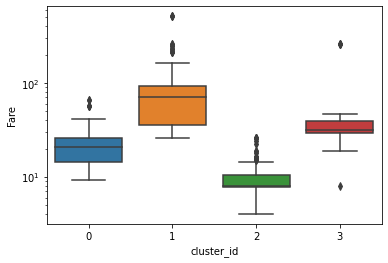

In [67]:
sns.boxplot(data=df_clustering, y='Fare', x='cluster_id')
plt.yscale('log')

- Q: Is Age different for point in different clusters?

- A: .....

<AxesSubplot:xlabel='cluster_id', ylabel='Age'>

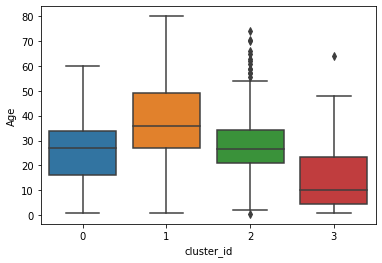

In [68]:
sns.boxplot(data=df_clustering, y='Age', x='cluster_id')


- Q: Does number of suvival differ in clusters?

- A: .....

<AxesSubplot:xlabel='cluster_id', ylabel='count'>

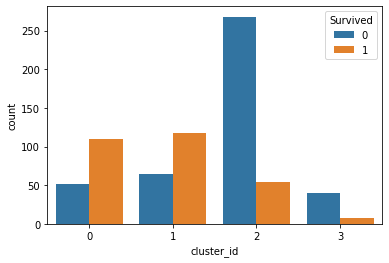

In [76]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

- Q: Does number of passanger of each class differ in clusters?

- A: .....

<AxesSubplot:xlabel='cluster_id', ylabel='count'>

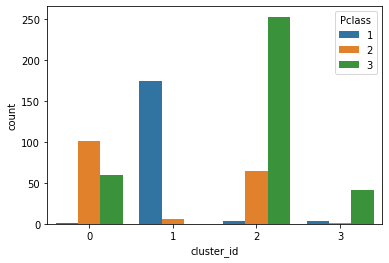

In [78]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass')

#### Write a textual description of clusters
Ve shluku 3 temer vsichni treti trida, vek relativne nizsi oproti ostatnim, placeno stredni cena listku.

# Is our data represented in the best way?

Clustering methods depends on calculation of distance metric among data points in our data matrix.

Therefore it is necessary to preproces our data matrix **X** in a best way possible to achive equal distance for every dataset feature. After such transformation we can count, that difference in age has same impact as difference in ticket class. Generally, it is very hard to create perfect tranformation for our real dataset.

#### Use StandardScaler transformation for our data **X**

In [69]:
col_names = ['Fare', 'Age', 'SibSp', 'Parch']
enc = sklearn.preprocessing.StandardScaler()
X_stand = pd.DataFrame(enc.fit_transform(df_clustering.loc[:, col_names]), columns = col_names, index=df_clustering.index)
X_stand = pd.concat([X_stand, df_encoded.loc[:, ['Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_clustering.Survived], axis=1)

In [70]:
X_stand

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,,
1,-0.516380,-0.527669,0.522511,-0.506787,1.0,0,0,1,0
2,0.694046,0.577094,0.522511,-0.506787,0.0,1,0,0,1
3,-0.503620,-0.251478,-0.552714,-0.506787,0.0,0,0,1,1
4,0.350326,0.369951,0.522511,-0.506787,0.0,0,0,1,1
5,-0.501257,0.369951,-0.552714,-0.506787,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
886,-0.102875,0.646142,-0.552714,5.350885,0.0,0,1,0,0
887,-0.407687,-0.182430,-0.552714,-0.506787,1.0,0,0,1,0
888,-0.086335,-0.734812,-0.552714,-0.506787,0.0,0,0,1,1


In [71]:
X_stand.describe()

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,712.000000,712.000000,712.000000,712.000000,712.000000
mean,-6.736185e-17,2.943962e-16,-1.496930e-17,1.496930e-17,0.636236,0.182584,0.039326,0.778090,0.404494
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,0.481420,0.386597,0.194506,0.415823,0.491139
min,-6.534272e-01,-2.017717e+00,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.012575e-01,-6.657639e-01,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-3.576726e-01,-1.133826e-01,-5.527137e-01,-5.067874e-01,1.000000,0.000000,0.000000,1.000000,0.000000
75%,-2.962586e-02,5.770939e-01,5.225108e-01,6.647471e-01,1.000000,0.000000,0.000000,1.000000,1.000000
max,9.031168e+00,3.477095e+00,4.823409e+00,6.522419e+00,1.000000,1.000000,1.000000,1.000000,1.000000


# Task (2p)
- Use **KMeans** to differently preprocessed data matrix **X_stand**
- Detect "ideal" number of clusters using Elbow method
- Explore detected clusters and **describe** them to the Markdown cell
